In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
zfile_dir = '/Volumes/1TB_BAY/zillow_sets/'
hood_dir = '/Volumes/1TB_BAY/zillow_sets/neighborhood_shapes/' #on my computer, the location of the neighborhood shape files
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'
fig_path = './paper/'

In [3]:
ah = pd.read_csv('Neighborhood_Zhvi_allhomes.csv') #all homes zhvi
sq = pd.read_csv('Neighborhood_MedianValuePerSqft_AllHomes.csv') #value per square foot

In [4]:
b = pd.read_csv('yelp_business_with_neighborhood.csv') #business file with zillow matches

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
ob = pd.read_csv(file_dir + 'yelp_academic_dataset_business.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,4,7,17,29,49,60,62,79,86,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


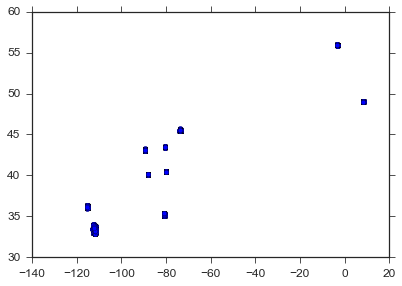

In [10]:
plt.scatter(ob['longitude'], ob['latitude'])

In [55]:
np.unique(b['state'], return_counts = True)

(array(['AL', 'AZ', 'CA', 'MN', 'NC', 'NM', 'NV', 'PA', 'TX', 'WI'], dtype=object),
 array([    1, 19958,     2,     1,  4853,     1,  9694,  2749,     1,  1355]))

In [60]:
nl = pd.read_csv('neighborhood_locations.csv')
nl.drop('Unnamed: 0', axis = 1, inplace = True)
nl.rename(columns = {'ID':'z_hood'}, inplace = True)

In [ ]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [61]:
from geopy.distance import great_circle # import a distance finding function

area = [] #initialize empty list to hold areas

for i in range(len(nl)):
    side_1 = (nl['lon'][i] - nl['lon_width'][i], nl['lat'][i])
    side_2 = (nl['lon'][i] + nl['lon_width'][i], nl['lat'][i])

    side_3 = (nl['lon'][i], nl['lat'][i] - nl['lat_width'][i])
    side_4 = (nl['lon'][i], nl['lat'][i] + nl['lat_width'][i])
    
    area.append(great_circle(side_1, side_2).miles*great_circle(side_3, side_4).miles)

In [62]:
nl['bbox_area'] = area

In [57]:
mean_price = []
mean_price_err = []
mean_stars = []
mean_stars_err = []
n_businesses = []
latest_zhvi = []
latest_sqft = []

for hoodid in np.unique(b['z_hood']):
    mean_price.append(np.mean(b['attributes.Price Range'][(b['z_hood'] == hoodid)]))
    mean_price_err.append(float(scipy.stats.sem(b['attributes.Price Range'].dropna()[(b['z_hood'] == hoodid)],ddof = 0, axis = None)))
    mean_stars.append(np.mean(b['stars'][(b['z_hood'] == hoodid)]))
    mean_stars_err.append(float(scipy.stats.sem(b['stars'][(b['z_hood'] == hoodid)], ddof = 0, axis = None)))
    n_businesses.append(len(b['stars'][(b['z_hood'] == hoodid)]))
    latest_zhvi.append(np.median(ah['2016-06'][(ah['RegionID'] == hoodid)]))
    latest_sqft.append(np.median(sq['2016-06'][(sq['RegionID'] == hoodid)]))

/Users/Franklin/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/Franklin/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [63]:
static = pd.DataFrame({'z_hood': np.unique(b['z_hood']),'mean_price': mean_price,'mean_price_err': mean_price_err, 'mean_stars': mean_stars,'mean_stars_err': mean_stars_err, 'n': n_businesses,\
                       'latest_zhvi': latest_zhvi, 'latest_sqft': latest_sqft}) #static information
st_f = static[(static['n'] >= 0.0)] #filtered static

In [64]:
st = st_f.merge(nl, how = 'inner', on = 'z_hood')

In [66]:
st.to_csv('static_stats.csv')

In [93]:
#create plotting format for use in all future analysis
marker_dict = {'AZ': 'bo', 'NC': 'g^', 'PA': 'rs', 'NV': 'm*', 'WI': 'kh'}

In [102]:
def StatePlot(x, y, st):
    for state in np.unique(st['state']):
        plt.errorbar(st[x][st['state'] == state], st[y][st['state'] == state], fmt = marker_dict[state], label = state, alpha = 0.7)
    sns.despine()
    plt.legend()

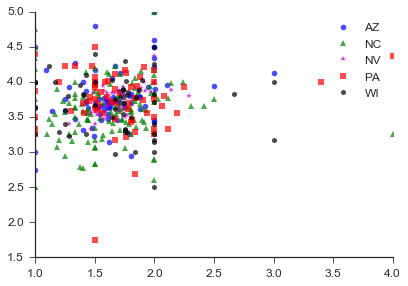

In [103]:
StatePlot('mean_price','mean_stars',st)

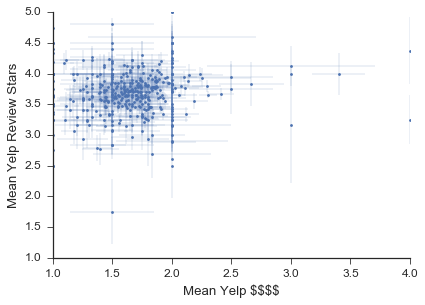

In [87]:
plt.figure()
plt.errorbar(st_f['mean_price'], st_f['mean_stars'],\
             np.array(st_f['mean_stars_err']),np.array(st_f['mean_price_err']),\
             fmt = '.', lw = 0.2)
plt.xlabel('Mean Yelp \$\$\$\$')
plt.ylabel('Mean Yelp Review Stars')
sns.despine()
#plt.savefig(fig_path + 'stars_price_scatter.png', fmt = 'png', dpi = 300)

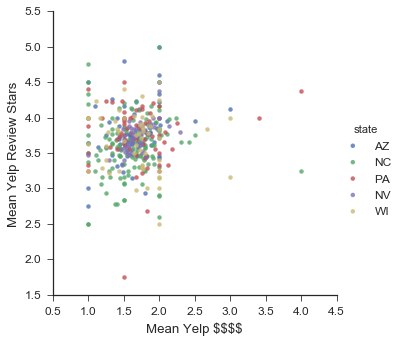

In [88]:
sns.lmplot(x = 'mean_price', y = 'mean_stars', data = st, hue = 'state', fit_reg = False)
plt.xlabel('Mean Yelp \$\$\$\$')
plt.ylabel('Mean Yelp Review Stars')
#plt.savefig(fig_path + 'stars_price_scatter_metro.png', fmt = 'png', dpi = 300)

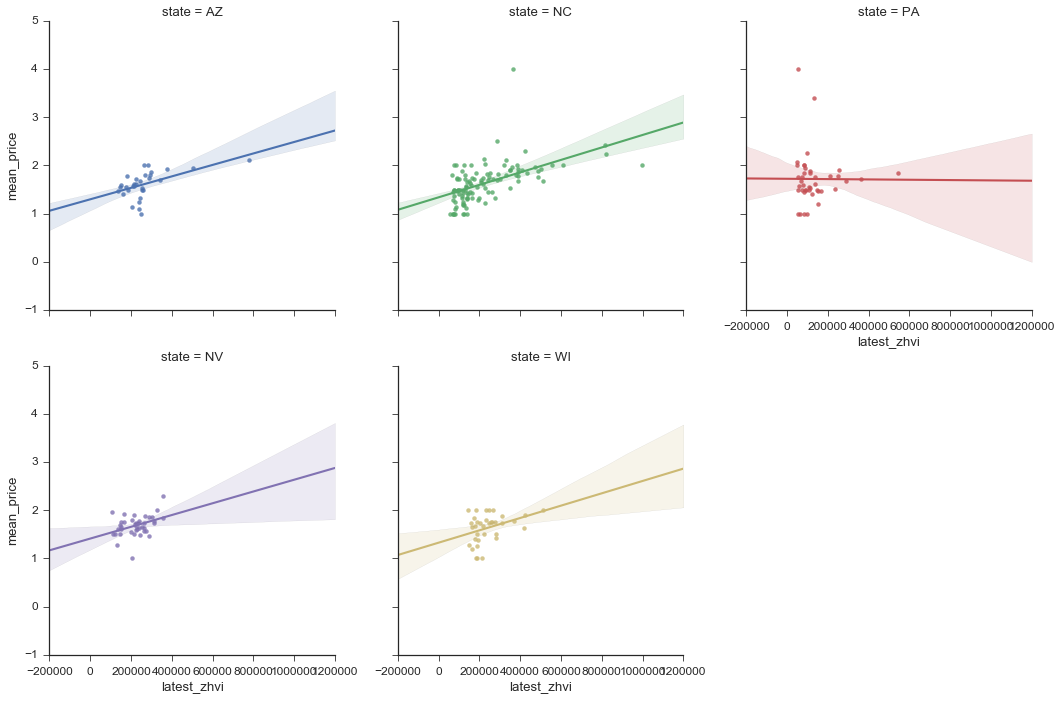

In [89]:
sns.lmplot('latest_zhvi','mean_price',data = st, hue = 'state',\
           col  = 'state', col_wrap = 3)

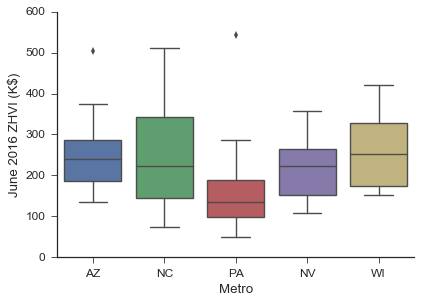

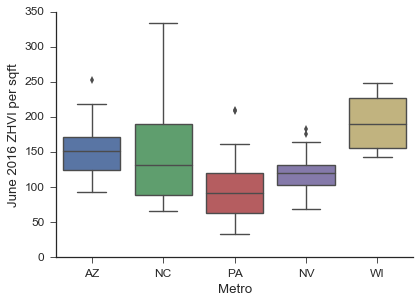

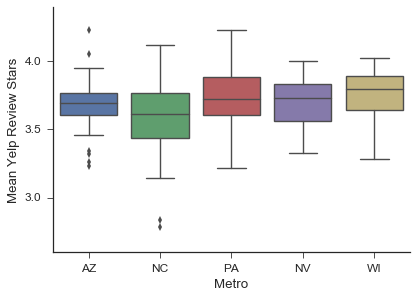

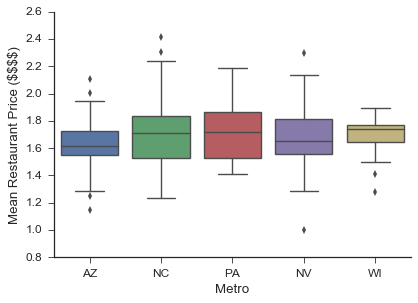

In [20]:
plt.figure()
sns.boxplot(x = st['state'], y = st['latest_zhvi']/1000.0)
plt.ylim(0,600)
plt.xlabel('Metro')
plt.ylabel('June 2016 ZHVI (K\$)')
sns.despine()
#plt.savefig(fig_path + 'metro_zhvi_box.png', fmt = 'png', dpi = 300)

plt.figure()
sns.boxplot(x = 'state', y = 'latest_sqft', data = st)
plt.xlabel('Metro')
plt.ylabel('June 2016 ZHVI per sqft')
sns.despine()
#plt.savefig(fig_path + 'metro_zhvisqft_box.png', fmt = 'png', dpi = 300)

plt.figure()
sns.boxplot(x = 'state', y = 'mean_stars', data = st)
plt.xlabel('Metro')
plt.ylabel('Mean Yelp Review Stars')
sns.despine()
#plt.savefig(fig_path + 'metro_stars_box.png', fmt = 'png', dpi = 300)

plt.figure()
sns.boxplot(x = 'state', y = 'mean_price', data = st)
plt.xlabel('Metro')
plt.ylabel('Mean Restaurant Price (\$\$\$\$)')
sns.despine()
#plt.savefig(fig_path + 'metro_price_box.png', fmt = 'png', dpi = 300)

In [142]:
st.columns

Index([u'latest_sqft', u'latest_zhvi', u'mean_price', u'mean_price_err',
       u'mean_stars', u'mean_stars_err', u'n', u'z_hood', u'loop_i', u'state',
       u'county', u'city', u'neighborhood', u'lon', u'lat', u'lon_width',
       u'lat_width'],
      dtype='object')

In [90]:
print(st.groupby('state').agg([np.median,np.mean, np.sum, len])['bbox_area'].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     median &       mean &          sum &  len \\
state &            &            &              &      \\
\midrule
AZ    &   0.478214 &  31.981832 &  2654.492091 &   83 \\
NC    &   2.008873 &   2.700059 &   372.608173 &  138 \\
NV    &  11.885273 &  21.630173 &  1081.508670 &   50 \\
PA    &   1.004904 &   1.246051 &    94.699852 &   76 \\
WI    &   0.043081 &   0.049007 &     3.234484 &   66 \\
\bottomrule
\end{tabular}



In [91]:
print(st.groupby('state').agg([np.median,np.mean, np.sum, len])['n'].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  median &        mean &    sum &  len \\
state &         &             &        &      \\
\midrule
AZ    &      20 &  240.469880 &  19959 &   83 \\
NC    &      16 &   35.173913 &   4854 &  138 \\
NV    &     129 &  193.940000 &   9697 &   50 \\
PA    &       8 &   36.171053 &   2749 &   76 \\
WI    &       7 &   20.545455 &   1356 &   66 \\
\bottomrule
\end{tabular}



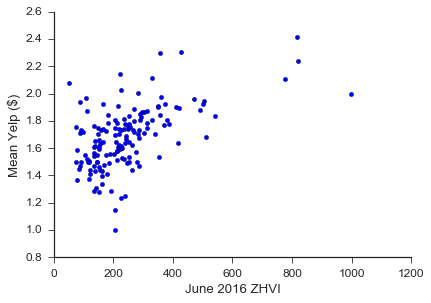

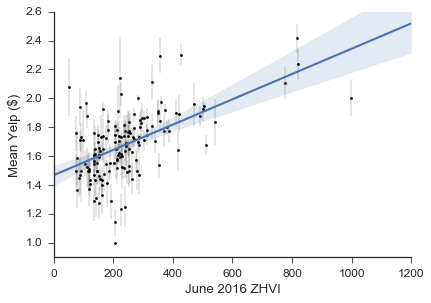

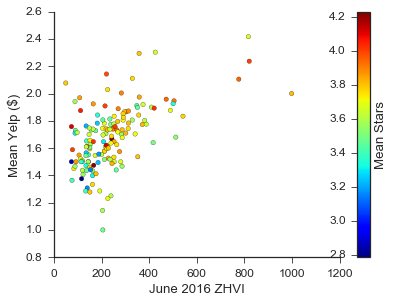

In [42]:
plt.figure()
plt.scatter(st_f['latest_zhvi']/1000.0, st_f['mean_price'], cmap = 'jet')
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
#plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()

plt.figure()
plt.errorbar(st['latest_zhvi']/1000.0, st['mean_price'], st['mean_price_err'], fmt = 'k.', lw = 0.2)
sns.regplot(st_f['latest_zhvi']/1000.0, st_f['mean_price'], st_f['mean_price_err'], scatter_kws = {'s': 0})
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
plt.ylim(0.9,2.6)
#plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()
plt.savefig(fig_path + 'ZHVI_price_reg.png', fmt = 'png', dpi = 300)

plt.figure()
plt.scatter(st_f['latest_zhvi']/1000.0, st_f['mean_price'], c = st_f['mean_stars'], cmap = 'jet')
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
plt.colorbar(label = 'Mean Stars')
sns.despine()

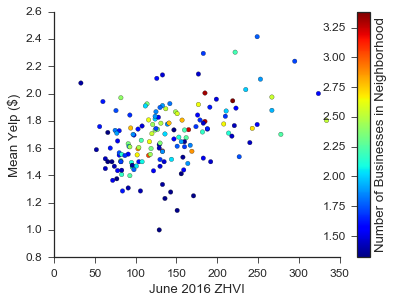

In [22]:
plt.figure()
plt.scatter(st_f['latest_sqft'], st_f['mean_price'], c = np.log10(st_f['n']), cmap = 'jet')
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()

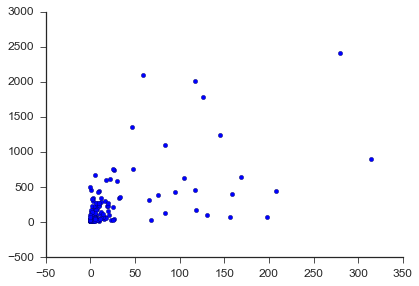

In [60]:
plt.scatter(st['bbox_area'], st['n'])
sns.despine()

(0.0001, 1000)

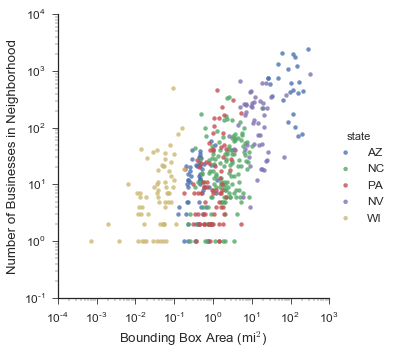

In [111]:
sns.lmplot(x = 'bbox_area', y = 'n', data = st, hue = 'state', fit_reg = False)
plt.xlabel('Bounding Box Area (mi$^2$)')
plt.ylabel('Number of Businesses in Neighborhood')
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.0001,1000)

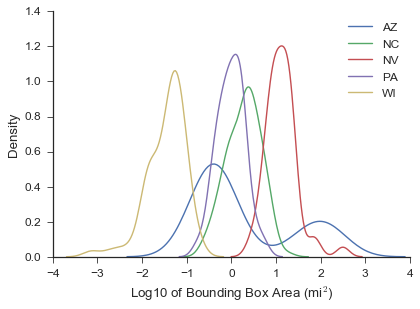

In [107]:
for state in np.unique(st['state']):
    sns.kdeplot(np.log10(st['bbox_area'][st['state'] == state]), label = state)
sns.despine()
plt.xlabel('Log10 of Bounding Box Area (mi$^{2}$)')
plt.ylabel('Density')

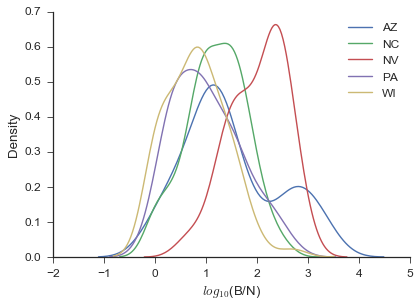

In [67]:
for state in np.unique(st['state']):
    sns.kdeplot(np.log10(st['n'][st['state'] == state]), label = state)
sns.despine()
plt.xlabel('$log_{10}$(B/N)')
plt.ylabel('Density')